# Introduction
* This program that classifies legal issues into a binary value for each National Subject Matter Index (NSMI). (https://nsmi.lsntap.org/browse-v2) \\
"Category" means 20 indexes. \\
"Class" means sub categories under the category.

### Data
* The data contains 2777 labeled articles. Each article has a binary value(0 or 1) that indicates if this article is related to a specific legal class. We ignore unlabeled entries when constructing a model.

### Implementation
* The program converts an article into tf-idf and applies multinomial Naive-Bayes model provided by scikit-learn. 

* After preprocessing data, we predict the model with 10-fold cross-validation.

### Output
* We calculate accuracy with bot categories(20) and classes(100+). \\

See overall result is at the bottom of this notebook.

# Data Preparation (DONE)

In [1]:
SOLVER = 'liblinear' 
PENALTY = "l1"


!pip3 install PrettyTable
!pip3 install pandas
!pip3 install sklearn
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install tqdm
!pip3 install nltk
!python3 -m nltk.downloader stopwords punkt
!python3 -m pip install prettytable

import os
import sys
import numpy as np
import pandas as pd
from collections import Counter
from collections import defaultdict

import sklearn.exceptions
import warnings
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import log_loss, make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
pd.options.display.max_rows = 100
pd.set_option('display.max_columns', None) 

import collections
import matplotlib.pyplot as plt
import pylab as pl


from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import punkt
stop_words = stopwords.words('english')

from tqdm.notebook import tqdm
import collections
from prettytable import PrettyTable


print("DONE")

/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /Users/heeh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/heeh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


DONE


In [2]:
url = 'https://raw.githubusercontent.com/heeh/legal_issue_classification/master/2019-12-06_95p-confidence_binary.csv'
df = pd.read_csv(url)
df.info()
df.iloc[:,:4]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2777 entries, 0 to 2776
Columns: 109 entries, _id to WO-09-00-00-00
dtypes: float64(107), object(2)
memory usage: 2.3+ MB


,_id,full_text,BE-00-00-00-00,BE-01-00-00-00
0,5b60e59cda52255c20cff794,Will he serve time?. Long story short my broth...,0.0,0.0
1,5b60e59cda52255c20cff79a,Groundwater leaking out of street 24/7. Ground...,0.0,0.0
2,5b60e59cda52255c20cff7a0,How do I get my mom's license taken away. My m...,0.0,0.0
3,5b60e59cda52255c20cff7bf,My boss hasn't paid me. What do i do?. I work ...,NaN,NaN
4,5b60e59cda52255c20cff7b8,"[Texas] I signed a non-compete contract, but t...",0.0,0.0
...,...,...,...,...
2772,5b60e66dda52255c20df433f,Do you and your parents get deported because o...,0.0,0.0
2773,5b60e66dda52255c20df43ae,Wondering the legality of a minor (me) being a...,0.0,0.0
2774,5b60e66dda52255c20df4462,Can I sue a billion dollar company in small cl...,0.0,0.0
2775,5b60e66dda52255c20df4448,Sued by creditor and currently in settlement n...,0.0,0.0


## Null and Rowsum Check

In [3]:

#Null Check
#df.isnull().sum()

# Class Check - Remove every column that has zero sum. 
df = df.loc[:, df.sum(axis=0, skipna=True) != 0]
temp = df.sum(axis = 0, skipna = True)


#df.info()


# Remove columns that have <10 positive classes

In [4]:
oldCols = list(df.columns)
print(len(oldCols))

newCols = []
for i,x in temp[2:].items():
    if x >= 10:
        newCols.append(i)
        
print(len(newCols))

cols = oldCols[:2] + newCols

print(cols)
print(len(cols))

df = df[cols]

df.sum(axis=0, skipna=True)

88
36
['_id', 'full_text', 'BE-00-00-00-00', 'BU-00-00-00-00', 'CO-00-00-00-00', 'CR-00-00-00-00', 'CR-01-00-00-00', 'CR-04-00-00-00', 'CR-06-00-00-00', 'CR-10-00-00-00', 'ED-00-00-00-00', 'ES-00-00-00-00', 'ES-01-00-00-00', 'ES-03-00-00-00', 'FA-00-00-00-00', 'FA-05-00-00-00', 'FA-06-00-00-00', 'FA-07-00-00-00', 'GO-00-00-00-00', 'HE-00-00-00-00', 'HO-00-00-00-00', 'HO-06-00-00-00', 'HO-09-00-00-00', 'IM-00-00-00-00', 'MO-00-00-00-00', 'MO-02-00-00-00', 'MO-07-00-00-00', 'MO-10-00-00-00', 'RI-00-00-00-00', 'TO-00-00-00-00', 'TR-00-00-00-00', 'TR-01-00-00-00', 'TR-02-00-00-00', 'TR-03-00-00-00', 'TR-04-00-00-00', 'TR-05-00-00-00', 'WO-00-00-00-00', 'WO-03-00-00-00']
38


_id               5b60e59cda52255c20cff7945b60e59cda52255c20cff7...
full_text         Will he serve time?. Long story short my broth...
BE-00-00-00-00                                                   27
BU-00-00-00-00                                                   93
CO-00-00-00-00                                                  106
CR-00-00-00-00                                                  302
CR-01-00-00-00                                                   12
CR-04-00-00-00                                                   13
CR-06-00-00-00                                                   11
CR-10-00-00-00                                                   11
ED-00-00-00-00                                                   24
ES-00-00-00-00                                                   78
ES-01-00-00-00                                                   10
ES-03-00-00-00                                                   13
FA-00-00-00-00                                  

# Tiny Example: Crime and Prison(CR-00-00-00-00)


## Preprocessing (DONE)

In [5]:

verbose = True
def preprocessing(dfset: defaultdict, cls: str):
    dfset[cls] = df.loc[:, ['_id', 'full_text', cls]]
    labels = dfset[cls].iloc[:,2]
    if verbose:
        print("------------Before dropping nan----------------------------------------")
        print(dfset[cls].iloc[:,1:])
        print(labels.value_counts(dropna=False))
    
    dfset[cls] = dfset[cls].dropna()
    labels = dfset[cls].iloc[:,2]
    if verbose:
        print("\n------------After dropping nan---------------------------------------")
        print(dfset[cls].iloc[:,1:])
        print(labels.value_counts(dropna=False))



## Data Preparation

In [6]:
cls = 'CR-00-00-00-00'
dfset = defaultdict() 
preprocessing(dfset, cls)    

#    model[cls] = make_pipeline(TfidfVectorizer(), MultinomialNB())
tinydf = dfset[cls]
X = tinydf['full_text'].values
Y = tinydf[cls].values

------------Before dropping nan----------------------------------------
                                              full_text  CR-00-00-00-00
0     Will he serve time?. Long story short my broth...             1.0
1     Groundwater leaking out of street 24/7. Ground...             0.0
2     How do I get my mom's license taken away. My m...             NaN
3     My boss hasn't paid me. What do i do?. I work ...             0.0
4     [Texas] I signed a non-compete contract, but t...             0.0
...                                                 ...             ...
2772  Do you and your parents get deported because o...             1.0
2773  Wondering the legality of a minor (me) being a...             0.0
2774  Can I sue a billion dollar company in small cl...             0.0
2775  Sued by creditor and currently in settlement n...             0.0
2776  (CA) Sales job. Income based on performance. A...             0.0

[2777 rows x 2 columns]
0.0    1377
NaN    1098
1.0     302
Nam

# GloVE

## Download and Load GloVe

In [7]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove.6B.zip

embeddings_index = {}
f = open('glove.6B.300d.txt', encoding="utf8")
for line in tqdm(f):
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except ValueError:
        pass
f.close()
print('Found %s word vectors.' % len(embeddings_index))


Found 400000 word vectors.


## GloVe Train & Predict

In [8]:
cls = 'CR-00-00-00-00'



# Train and Test Split
p = len(X) // 10 * 9
train_text = X[:p]
test_text = X[p:]


print("Checkpoint1 - Data Read Complete")


hit = 0
all_words = 0
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    global hit, all_words
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    hit += len(M)
    all_words += len(words)
    
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

# create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec(x) for x in tqdm(train_text)]

print('Mean Train Word Hit Rate(\%)', hit / all_words * 100)
hit = 0
all_words = 0

xtest_glove = [sent2vec(x) for x in tqdm(test_text)]
print('Mean Test Word Hit Rate(\%)', hit / all_words * 100)

print('Checkpoint2 -Normalized Vector for Sentences are created')

xtrain_glove = np.array(xtrain_glove)
xtest_glove = np.array(xtest_glove)

model = LogisticRegression(penalty=PENALTY, solver=SOLVER, class_weight='balanced')

train_target = Y[:p]
test_target = Y[p:]

model.fit(xtrain_glove, train_target)
preds = model.predict(xtest_glove)

print(preds)
accuracy = accuracy_score(test_target, preds)
precision, recall, fscore, support = score(test_target, preds)
print('accuracy: {}'.format(accuracy))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

Checkpoint1 - Data Read Complete



Mean Train Word Hit Rate(\%) 99.58181372991224



Mean Test Word Hit Rate(\%) 99.61077662227088
Checkpoint2 -Normalized Vector for Sentences are created
[1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 0.]
accuracy: 0.9034090909090909
precision: [0.99275362 0.57894737]
recall: [0.89542484 0.95652174]
fscore: [0.94158076 0.72131148]
support: [153  23]


## GloVE + Logistic Regression on CR-00-00-00-00

In [9]:

verbose = False
    
numdoc = defaultdict()

classifier = defaultdict()

    
def predict_by_class_glove(dfset: defaultdict,cls: str) -> float:
    global PENALTY, SOLVER
    preprocessing(dfset, cls)
    tinydf = dfset[cls]
    X = tinydf['full_text'].values
    Y = tinydf[cls].values
    X_glove = [sent2vec(x) for x in tqdm(X)]
    X_glove = np.array(X_glove)
    
    
    print('------------------------------------\n')
    labels = dfset[cls].iloc[:,2]
    print(labels.value_counts(dropna=False))

    # 10-fold separation with train and test 
    #kfold = KFold(n_splits=10)
    kfold = KFold(n_splits=10)
    print('data set size', len(X_glove))
    numdoc[cls] = len(X_glove)
    n_iter = 0
    acc_list = []
    pre_list = []
    rec_list = []
    fsc_list = []
    sup_list = []

    
    preds = [0] * len(Y)
    probs = [0] * len(Y)
    
    print('Checkpoint2 -Normalized Vector for Sentences are created')
    


    for train_index, test_index in kfold.split(X_glove, Y):

        X_train, X_test = X_glove[train_index], X_glove[test_index] 
        Y_train, Y_test = Y[train_index], Y[test_index]

        # Scikit-Learn
        classifier[cls] = LogisticRegression(penalty=PENALTY, solver=SOLVER, class_weight='balanced', max_iter=2000)
        classifier[cls].fit(X_train, Y_train)
        out = classifier[cls].predict(X_test)
        prob = classifier[cls].predict_proba(X_test)[:,1]
        
        

        #print(len(out))
        i = 0
        for x in test_index:
            preds[x] = out[i]
            probs[x] = prob[i]
            i += 1
            
        #print(preds)

        n_iter += 1
        
    custom_logloss = np.round(log_loss(Y, probs), 4)
    custom_brierloss = np.round(brier_score_loss(Y, probs), 4)
    print('logloss:', custom_logloss)
    print('brierloss: ',custom_brierloss)
    
    accuracy = accuracy_score(Y, preds)
    precision, recall, fscore, support = score(Y, preds)
    # accuracy: (tp + tn) / (p + n)
    # precision tp / (tp + fp)
    # recall:   tp / (tp + fn)
    # f1: 2 tp / (2 tp + fp + fn)
    accuracy = np.round(accuracy, 4)
    precision[1] = np.round(precision[1], 4)
    recall[1] = np.round(recall[1], 4)
    fscore[1] = np.round(fscore[1], 4)
    support[1] = np.round(support[1], 4)
    
    
    return (accuracy, precision[1], recall[1], fscore[1], support[1], custom_logloss, custom_brierloss)



#cls = 'BE-00-00-00-00'
cls = 'CR-00-00-00-00'
predict_by_class_glove(dfset, cls)


------------------------------------

0.0    1377
1.0     302
Name: CR-00-00-00-00, dtype: int64
data set size 1679
Checkpoint2 -Normalized Vector for Sentences are created
logloss: 0.3237
brierloss:  0.0964


(0.8785, 0.6219, 0.8278, 0.7102, 302, 0.3237, 0.0964)

## GloVe GridSearch


------------------------------------

0.0    1377
1.0     302
Name: CR-00-00-00-00, dtype: int64
data set size 1679



C: 32.0 0.3583



C: 16.0 0.2898



C: 8.0 0.2588



C: 4.0 0.2552



C: 2.0 0.2768



C: 1.0 0.3237
(0.8958, 0.6624, 0.8576, 0.7475, 302, 0.2552, 0.0741, 4.0, 1679)


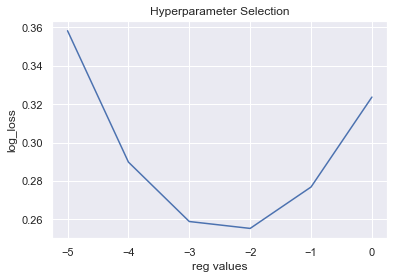

4.0


In [10]:
verbose = False
numdoc = defaultdict()
classifier = defaultdict()

    
def predict_by_class_glove_grid(dfset: defaultdict,cls: str) -> float:
    global PENALTY, SOLVER
    preprocessing(dfset, cls)
    tinydf = dfset[cls]
    X = tinydf['full_text'].values
    Y = tinydf[cls].values
    X_glove = [sent2vec(x) for x in tqdm(X)]
    X_glove = np.array(X_glove)

    print('------------------------------------\n')
    labels = dfset[cls].iloc[:,2]
    print(labels.value_counts(dropna=False))
    kfold = KFold(n_splits=10)
    print('data set size', len(X_glove))
    numdoc[cls] = len(X_glove)
    n_iter = 0
    acc_list = []
    pre_list = []
    rec_list = []
    fsc_list = []
    sup_list = []

    
    preds = [0] * len(Y)
    probs = [0] * len(Y)

    best_recall = 0
    best_accuracy = 0
    best_precision = 0
    best_fscore = 0
    best_support = 0
    best_model = 0
    best_c = 0
    
    best_logloss = 1
    best_brierloss = 1
    
    model = None


    for reg in range(-5, 1):
        
        c = 1.0/2.0**reg

        model = LogisticRegression(penalty=PENALTY, solver=SOLVER, class_weight='balanced', max_iter=2000, C = c)
        
        for train_index, test_index in tqdm(kfold.split(X_glove, Y)):
            X_train, X_test = X_glove[train_index], X_glove[test_index] 
            Y_train, Y_test = Y[train_index], Y[test_index]
            model.fit(X_train, Y_train)
            out = model.predict(X_test)
            prob = model.predict_proba(X_test)[:,1]

            i = 0
            for x in test_index:
                preds[x] = out[i]
                probs[x] = prob[i]
                i += 1
            n_iter += 1

            
        custom_logloss = np.round(log_loss(Y, probs), 4)
        custom_brierloss = np.round(brier_score_loss(Y, probs), 4)  
        
        c_list.append(reg)
        loss_list.append(custom_logloss)
        print('C:', c, end=' ')
        print(custom_logloss)

        accuracy = accuracy_score(Y, preds)
        precision, recall, fscore, support = score(Y, preds)
        # accuracy: (tp + tn) / (p + n)
        # precision tp / (tp + fp)
        # recall:   tp / (tp + fn)
        # f1: 2 tp / (2 tp + fp + fn)
        accuracy = np.round(accuracy, 4)
        precision[1] = np.round(precision[1], 4)
        recall[1] = np.round(recall[1], 4)
        fscore[1] = np.round(fscore[1], 4)
        support[1] = np.round(support[1], 4)

#        if best_recall < recall[1]:
        if best_logloss > custom_logloss:
            best_logloss = custom_logloss
            best_accuracy = accuracy
            best_recall = recall[1]
            best_precision = precision[1]
            best_fscore = fscore[1]
            best_support = support[1]
            best_model = model
            best_c = c
        if best_brierloss > custom_brierloss:
            best_brierloss = custom_brierloss
            
    classifier[cls] = best_model
    return (best_accuracy, best_precision, best_recall, best_fscore, best_support, best_logloss, best_brierloss, best_c, numdoc[cls])

c_list = []
loss_list = []

cls = 'CR-00-00-00-00'
print(predict_by_class_glove_grid(dfset, cls))



# plotting the points  
plt.plot(range(-5,1), loss_list)  
plt.xlabel('reg values') 
plt.ylabel('log_loss') 
plt.title('Hyperparameter Selection') 
plt.show() 
print(classifier[cls].C)

# Entire Data 

## Build Models and Calculating Accuracies

In [11]:


class_list = df.columns[2:]
print(class_list)
verbose = False
stat_dict = defaultdict() 
for cls in tqdm(class_list):
    ret = predict_by_class_glove_grid(dfset, cls)
    stat_dict[cls] = ret 
    print('statistics' , ret)

Index(['BE-00-00-00-00', 'BU-00-00-00-00', 'CO-00-00-00-00', 'CR-00-00-00-00',
       'CR-01-00-00-00', 'CR-04-00-00-00', 'CR-06-00-00-00', 'CR-10-00-00-00',
       'ED-00-00-00-00', 'ES-00-00-00-00', 'ES-01-00-00-00', 'ES-03-00-00-00',
       'FA-00-00-00-00', 'FA-05-00-00-00', 'FA-06-00-00-00', 'FA-07-00-00-00',
       'GO-00-00-00-00', 'HE-00-00-00-00', 'HO-00-00-00-00', 'HO-06-00-00-00',
       'HO-09-00-00-00', 'IM-00-00-00-00', 'MO-00-00-00-00', 'MO-02-00-00-00',
       'MO-07-00-00-00', 'MO-10-00-00-00', 'RI-00-00-00-00', 'TO-00-00-00-00',
       'TR-00-00-00-00', 'TR-01-00-00-00', 'TR-02-00-00-00', 'TR-03-00-00-00',
       'TR-04-00-00-00', 'TR-05-00-00-00', 'WO-00-00-00-00', 'WO-03-00-00-00'],
      dtype='object')



------------------------------------

0.0    1821
1.0      27
Name: BE-00-00-00-00, dtype: int64
data set size 1848



C: 32.0 0.0881



C: 16.0 0.0835



C: 8.0 0.094



C: 4.0 0.1191



C: 2.0 0.1576



C: 1.0 0.2196
statistics (0.9719, 0.2549, 0.4815, 0.3333, 27, 0.0835, 0.0198, 16.0, 1848)



------------------------------------

0.0    1497
1.0      93
Name: BU-00-00-00-00, dtype: int64
data set size 1590



C: 32.0 0.1176



C: 16.0 0.1038



C: 8.0 0.1057



C: 4.0 0.1203



C: 2.0 0.1468



C: 1.0 0.1925
statistics (0.961, 0.6281, 0.8172, 0.7103, 93, 0.1038, 0.0297, 16.0, 1590)



------------------------------------

0.0    1058
1.0     106
Name: CO-00-00-00-00, dtype: int64
data set size 1164



C: 32.0 0.2182



C: 16.0 0.1941



C: 8.0 0.1922



C: 4.0 0.2116



C: 2.0 0.2529



C: 1.0 0.32
statistics (0.9287, 0.5816, 0.7736, 0.664, 106, 0.1922, 0.0521, 8.0, 1164)



------------------------------------

0.0    1377
1.0     302
Name: CR-00-00-00-00, dtype: int64
data set size 1679



C: 32.0 0.3583



C: 16.0 0.2898



C: 8.0 0.2588



C: 4.0 0.2552



C: 2.0 0.2768



C: 1.0 0.3237
statistics (0.8958, 0.6624, 0.8576, 0.7475, 302, 0.2552, 0.0741, 4.0, 1679)



------------------------------------

0.0    1381
1.0      12
Name: CR-01-00-00-00, dtype: int64
data set size 1393



C: 32.0 0.1075



C: 16.0 0.098



C: 8.0 0.0984



C: 4.0 0.1168



C: 2.0 0.1629



C: 1.0 0.2477
statistics (0.9749, 0.04, 0.0833, 0.0541, 12, 0.098, 0.0196, 16.0, 1393)



------------------------------------

0.0    1389
1.0      13
Name: CR-04-00-00-00, dtype: int64
data set size 1402



C: 32.0 0.0871



C: 16.0 0.084



C: 8.0 0.094



C: 4.0 0.1224



C: 2.0 0.1768



C: 1.0 0.2599
statistics (0.975, 0.1071, 0.2308, 0.1463, 13, 0.084, 0.018, 16.0, 1402)



------------------------------------

0.0    1393
1.0      11
Name: CR-06-00-00-00, dtype: int64
data set size 1404



C: 32.0 0.0556



C: 16.0 0.058



C: 8.0 0.0684



C: 4.0 0.0897



C: 2.0 0.1324



C: 1.0 0.2065
statistics (0.985, 0.1875, 0.2727, 0.2222, 11, 0.0556, 0.0125, 32.0, 1404)



------------------------------------

0.0    1958
1.0      11
Name: CR-10-00-00-00, dtype: int64
data set size 1969



C: 32.0 0.0826



C: 16.0 0.0784



C: 8.0 0.081



C: 4.0 0.0959



C: 2.0 0.1278



C: 1.0 0.1907
statistics (0.9792, 0.0312, 0.0909, 0.0465, 11, 0.0784, 0.0163, 16.0, 1969)



------------------------------------

0.0    1789
1.0      24
Name: ED-00-00-00-00, dtype: int64
data set size 1813



C: 32.0 0.0693



C: 16.0 0.063



C: 8.0 0.0622



C: 4.0 0.0723



C: 2.0 0.0995



C: 1.0 0.15
statistics (0.9807, 0.3659, 0.625, 0.4615, 24, 0.0622, 0.0148, 8.0, 1813)



------------------------------------

0.0    1866
1.0      78
Name: ES-00-00-00-00, dtype: int64
data set size 1944



C: 32.0 0.0863



C: 16.0 0.0827



C: 8.0 0.0936



C: 4.0 0.1182



C: 2.0 0.1587



C: 1.0 0.2174
statistics (0.9666, 0.5546, 0.8462, 0.6701, 78, 0.0827, 0.0229, 16.0, 1944)



------------------------------------

0.0    1866
1.0      10
Name: ES-01-00-00-00, dtype: int64
data set size 1876



C: 32.0 0.0659



C: 16.0 0.0641



C: 8.0 0.0682



C: 4.0 0.0854



C: 2.0 0.1162



C: 1.0 0.166
statistics (0.9829, 0.0769, 0.2, 0.1111, 10, 0.0641, 0.0128, 16.0, 1876)



------------------------------------

0.0    1979
1.0      13
Name: ES-03-00-00-00, dtype: int64
data set size 1992



C: 32.0 0.0722



C: 16.0 0.0712



C: 8.0 0.0814



C: 4.0 0.104



C: 2.0 0.1387



C: 1.0 0.1945
statistics (0.9769, 0.0976, 0.3077, 0.1481, 13, 0.0712, 0.015, 16.0, 1992)



------------------------------------

0.0    1685
1.0     357
Name: FA-00-00-00-00, dtype: int64
data set size 2042



C: 32.0 0.2595



C: 16.0 0.2093



C: 8.0 0.1894



C: 4.0 0.1934



C: 2.0 0.2154



C: 1.0 0.26
statistics (0.9285, 0.7459, 0.8964, 0.8142, 357, 0.1894, 0.055, 8.0, 2042)



------------------------------------

0.0    2001
1.0      10
Name: FA-05-00-00-00, dtype: int64
data set size 2011



C: 32.0 0.0567



C: 16.0 0.0575



C: 8.0 0.0629



C: 4.0 0.079



C: 2.0 0.1105



C: 1.0 0.1595
statistics (0.9871, 0.1, 0.2, 0.1333, 10, 0.0567, 0.0112, 32.0, 2011)



------------------------------------

0.0    1781
1.0      10
Name: FA-06-00-00-00, dtype: int64
data set size 1791



C: 32.0 0.0575



C: 16.0 0.0614



C: 8.0 0.0715



C: 4.0 0.0938



C: 2.0 0.1321



C: 1.0 0.1966
statistics (0.9855, 0.1, 0.2, 0.1333, 10, 0.0575, 0.0116, 32.0, 1791)



------------------------------------

0.0    1927
1.0      41
Name: FA-07-00-00-00, dtype: int64
data set size 1968



C: 32.0 0.164



C: 16.0 0.151



C: 8.0 0.1594



C: 4.0 0.1883



C: 2.0 0.2378



C: 1.0 0.3113
statistics (0.9522, 0.2268, 0.5366, 0.3188, 41, 0.151, 0.0353, 16.0, 1968)



------------------------------------

0.0    1504
1.0      13
Name: GO-00-00-00-00, dtype: int64
data set size 1517



C: 32.0 0.0852



C: 16.0 0.0814



C: 8.0 0.0882



C: 4.0 0.109



C: 2.0 0.1512



C: 1.0 0.2281
statistics (0.9769, 0.0769, 0.1538, 0.1026, 13, 0.0814, 0.0174, 16.0, 1517)



------------------------------------

0.0    1778
1.0     122
Name: HE-00-00-00-00, dtype: int64
data set size 1900



C: 32.0 0.098



C: 16.0 0.0896



C: 8.0 0.0919



C: 4.0 0.1069



C: 2.0 0.1333



C: 1.0 0.1779
statistics (0.9721, 0.7447, 0.8607, 0.7985, 122, 0.0896, 0.0228, 16.0, 1900)



------------------------------------

0.0    1582
1.0     550
Name: HO-00-00-00-00, dtype: int64
data set size 2132



C: 32.0 0.1446



C: 16.0 0.1201



C: 8.0 0.1133



C: 4.0 0.1245



C: 2.0 0.1532



C: 1.0 0.2027
statistics (0.9629, 0.9139, 0.9455, 0.9294, 550, 0.1133, 0.0305, 8.0, 2132)



------------------------------------

0.0    1628
1.0      34
Name: HO-06-00-00-00, dtype: int64
data set size 1662



C: 32.0 0.1023



C: 16.0 0.0948



C: 8.0 0.1051



C: 4.0 0.1318



C: 2.0 0.1741



C: 1.0 0.2447
statistics (0.9705, 0.3636, 0.5882, 0.4494, 34, 0.0948, 0.0243, 16.0, 1662)



------------------------------------

0.0    1626
1.0      27
Name: HO-09-00-00-00, dtype: int64
data set size 1653



C: 32.0 0.0657



C: 16.0 0.0663



C: 8.0 0.0721



C: 4.0 0.0898



C: 2.0 0.1258



C: 1.0 0.189
statistics (0.9806, 0.4242, 0.5185, 0.4667, 27, 0.0657, 0.0153, 32.0, 1653)



------------------------------------

0.0    1928
1.0      36
Name: IM-00-00-00-00, dtype: int64
data set size 1964



C: 32.0 0.0407



C: 16.0 0.0435



C: 8.0 0.0497



C: 4.0 0.0645



C: 2.0 0.0914



C: 1.0 0.1379
statistics (0.9888, 0.6842, 0.7222, 0.7027, 36, 0.0407, 0.0103, 32.0, 1964)



------------------------------------

0.0    1063
1.0     366
Name: MO-00-00-00-00, dtype: int64
data set size 1429



C: 32.0 0.3966



C: 16.0 0.337



C: 8.0 0.3076



C: 4.0 0.3012



C: 2.0 0.3264



C: 1.0 0.3807
statistics (0.8803, 0.7262, 0.8552, 0.7854, 366, 0.3012, 0.0913, 4.0, 1429)



------------------------------------

0.0    1937
1.0      12
Name: MO-02-00-00-00, dtype: int64
data set size 1949



C: 32.0 0.0721



C: 16.0 0.068



C: 8.0 0.0709



C: 4.0 0.0868



C: 2.0 0.117



C: 1.0 0.1688
statistics (0.9805, 0.0667, 0.1667, 0.0952, 12, 0.068, 0.0147, 16.0, 1949)



------------------------------------

0.0    1116
1.0      13
Name: MO-07-00-00-00, dtype: int64
data set size 1129



C: 32.0 0.0637



C: 16.0 0.0672



C: 8.0 0.0746



C: 4.0 0.0922



C: 2.0 0.1296



C: 1.0 0.1996
statistics (0.9796, 0.2917, 0.5385, 0.3784, 13, 0.0637, 0.0164, 32.0, 1129)



------------------------------------

0.0    1095
1.0      11
Name: MO-10-00-00-00, dtype: int64
data set size 1106



C: 32.0 0.0732



C: 16.0 0.0735



C: 8.0 0.0837



C: 4.0 0.1103



C: 2.0 0.1562



C: 1.0 0.2429
statistics (0.9792, 0.125, 0.1818, 0.1481, 11, 0.0732, 0.0162, 32.0, 1106)



------------------------------------

0.0    1374
1.0      22
Name: RI-00-00-00-00, dtype: int64
data set size 1396



C: 32.0 0.164



C: 16.0 0.1546



C: 8.0 0.1602



C: 4.0 0.1873



C: 2.0 0.2457



C: 1.0 0.3278
statistics (0.9606, 0.1163, 0.2273, 0.1538, 22, 0.1546, 0.0315, 16.0, 1396)



------------------------------------

0.0    1027
1.0     230
Name: TO-00-00-00-00, dtype: int64
data set size 1257



C: 32.0 0.3883



C: 16.0 0.3286



C: 8.0 0.295



C: 4.0 0.3013



C: 2.0 0.3305



C: 1.0 0.3836
statistics (0.8783, 0.6254, 0.8348, 0.7151, 230, 0.295, 0.0891, 8.0, 1257)



------------------------------------

0.0    1746
1.0     260
Name: TR-00-00-00-00, dtype: int64
data set size 2006



C: 32.0 0.1479



C: 16.0 0.128



C: 8.0 0.1285



C: 4.0 0.1356



C: 2.0 0.1546



C: 1.0 0.1906
statistics (0.9641, 0.8333, 0.9038, 0.8672, 260, 0.128, 0.031, 16.0, 2006)



------------------------------------

0.0    1805
1.0      22
Name: TR-01-00-00-00, dtype: int64
data set size 1827



C: 32.0 0.0939



C: 16.0 0.0861



C: 8.0 0.0864



C: 4.0 0.0952



C: 2.0 0.1202



C: 1.0 0.1644
statistics (0.9754, 0.2444, 0.5, 0.3284, 22, 0.0861, 0.0191, 16.0, 1827)



------------------------------------

0.0    1790
1.0      29
Name: TR-02-00-00-00, dtype: int64
data set size 1819



C: 32.0 0.1066



C: 16.0 0.1004



C: 8.0 0.1044



C: 4.0 0.1224



C: 2.0 0.159



C: 1.0 0.2121
statistics (0.9731, 0.3148, 0.5862, 0.4096, 29, 0.1004, 0.0202, 16.0, 1819)



------------------------------------

0.0    1804
1.0      17
Name: TR-03-00-00-00, dtype: int64
data set size 1821



C: 32.0 0.0905



C: 16.0 0.0819



C: 8.0 0.0849



C: 4.0 0.0978



C: 2.0 0.1257



C: 1.0 0.1683
statistics (0.9813, 0.1852, 0.2941, 0.2273, 17, 0.0819, 0.0166, 16.0, 1821)



------------------------------------

0.0    1795
1.0      20
Name: TR-04-00-00-00, dtype: int64
data set size 1815



C: 32.0 0.0914



C: 16.0 0.0851



C: 8.0 0.0836



C: 4.0 0.0902



C: 2.0 0.1099



C: 1.0 0.1459
statistics (0.9736, 0.2308, 0.6, 0.3333, 20, 0.0836, 0.0184, 8.0, 1815)



------------------------------------

0.0    1785
1.0      31
Name: TR-05-00-00-00, dtype: int64
data set size 1816



C: 32.0 0.0431



C: 16.0 0.0445



C: 8.0 0.0515



C: 4.0 0.0682



C: 2.0 0.0981



C: 1.0 0.1461
statistics (0.9857, 0.5581, 0.7742, 0.6486, 31, 0.0431, 0.0113, 32.0, 1816)



------------------------------------

0.0    1604
1.0     387
Name: WO-00-00-00-00, dtype: int64
data set size 1991



C: 32.0 0.2521



C: 16.0 0.2004



C: 8.0 0.1866



C: 4.0 0.1971



C: 2.0 0.2167



C: 1.0 0.259
statistics (0.9332, 0.7981, 0.8786, 0.8364, 387, 0.1866, 0.0522, 8.0, 1991)



------------------------------------

0.0    1607
1.0      10
Name: WO-03-00-00-00, dtype: int64
data set size 1617



C: 32.0 0.0733



C: 16.0 0.0747



C: 8.0 0.0837



C: 4.0 0.1051



C: 2.0 0.1442



C: 1.0 0.2081
statistics (0.9827, 0.0909, 0.2, 0.125, 10, 0.0733, 0.0137, 32.0, 1617)



In [12]:
import pickle
with open("models_glove_l1_300d.pckl", "wb") as f:
    for val in classifier.items():
         pickle.dump(val, f)
            
            
with open("stats_glove_l1_300d.pckl", "wb") as f:
    for val in stat_dict.items():
         pickle.dump(val, f)

## C Values

In [13]:
for cls in class_list:
    print(classifier[cls].C)

16.0
16.0
8.0
4.0
16.0
16.0
32.0
16.0
8.0
16.0
16.0
16.0
8.0
32.0
32.0
16.0
16.0
16.0
8.0
16.0
32.0
32.0
4.0
16.0
32.0
32.0
16.0
8.0
16.0
16.0
16.0
16.0
8.0
32.0
8.0
32.0


## Distribution

In [21]:

t = PrettyTable(["class", "accuracy", "precision", "recall", "F1", "sup", "log_loss", "brier_loss", "C", "|documents|"])
#t.align["class"] = "r"
t.align["accuracy"] = "r"
t.align["precision"] = "r"
t.align["recall"] = "r"
t.align["F1 score"] = "r"
t.align["support"] = "r"
t.align["log_loss"] = "r"
t.align["brier_loss"] = "r"
t.align["C"] = "r"

for k,v in stat_dict.items():
    t.add_row([k, v[0], v[1], v[2], v[3], v[4], v[5], v[6], v[7], numdoc[k]])
    
print(t)

+----------------+----------+-----------+--------+--------+-----+----------+------------+------+-------------+
|     class      | accuracy | precision | recall |   F1   | sup | log_loss | brier_loss |    C | |documents| |
+----------------+----------+-----------+--------+--------+-----+----------+------------+------+-------------+
| BE-00-00-00-00 |   0.9719 |    0.2549 | 0.4815 | 0.3333 |  27 |   0.0835 |     0.0198 | 16.0 |     1848    |
| BU-00-00-00-00 |    0.961 |    0.6281 | 0.8172 | 0.7103 |  93 |   0.1038 |     0.0297 | 16.0 |     1590    |
| CO-00-00-00-00 |   0.9287 |    0.5816 | 0.7736 | 0.664  | 106 |   0.1922 |     0.0521 |  8.0 |     1164    |
| CR-00-00-00-00 |   0.8958 |    0.6624 | 0.8576 | 0.7475 | 302 |   0.2552 |     0.0741 |  4.0 |     1679    |
| CR-01-00-00-00 |   0.9749 |      0.04 | 0.0833 | 0.0541 |  12 |    0.098 |     0.0196 | 16.0 |     1393    |
| CR-04-00-00-00 |    0.975 |    0.1071 | 0.2308 | 0.1463 |  13 |    0.084 |      0.018 | 16.0 |     1402    |
|

## Plotting for Top10 classes

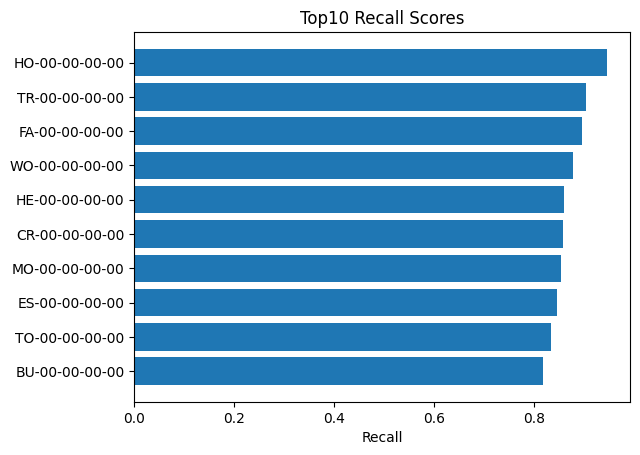

In [15]:


# Fixing random state for reproducibility
np.random.seed(19680801)


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(10)
error = 0 

recall_dict = defaultdict()
for k,v in stat_dict.items():
    recall_dict[k] = v[2]

sorted_x = sorted(recall_dict.items(), key=lambda kv: kv[1], reverse=True)
topcat_dict = collections.OrderedDict(sorted_x)
#print(topcat_dict)

keyList = []
valList = []
for kv in topcat_dict.items():
    keyList.append(kv[0])
    valList.append(kv[1])

ax.barh(y_pos[:10], valList[:10], xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(keyList[:10])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Recall')
ax.set_title('Top10 Recall Scores')

plt.show()

## Bottom 10

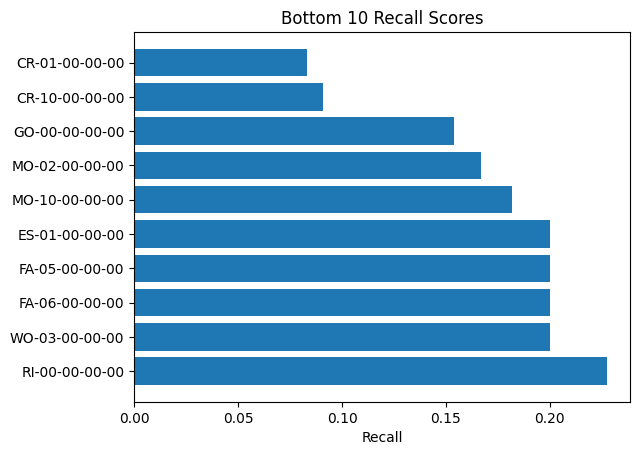

In [16]:


# Fixing random state for reproducibility
np.random.seed(19680801)


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(10)
error = 0 

recall_dict = defaultdict()
for k,v in stat_dict.items():
    recall_dict[k] = v[2]
    
sorted_x = sorted(recall_dict.items(), key=lambda kv: kv[1])
topcat_dict = collections.OrderedDict(sorted_x)
#print(topcat_dict)

keyList = []
valList = []
for kv in topcat_dict.items():
    keyList.append(kv[0])
    valList.append(kv[1])




ax.barh(y_pos[:10], valList[:10], xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(keyList[:10])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Recall')
ax.set_title('Bottom 10 Recall Scores')

plt.show()

## Recall Distribution

    Recall
0    48.15
1    81.72
2    77.36
3    85.76
4     8.33
5    23.08
6    27.27
7     9.09
8    62.50
9    84.62
10   20.00
11   30.77
12   89.64
13   20.00
14   20.00
15   53.66
16   15.38
17   86.07
18   94.55
19   58.82
20   51.85
21   72.22
22   85.52
23   16.67
24   53.85
25   18.18
26   22.73
27   83.48
28   90.38
29   50.00
30   58.62
31   29.41
32   60.00
33   77.42
34   87.86
35   20.00


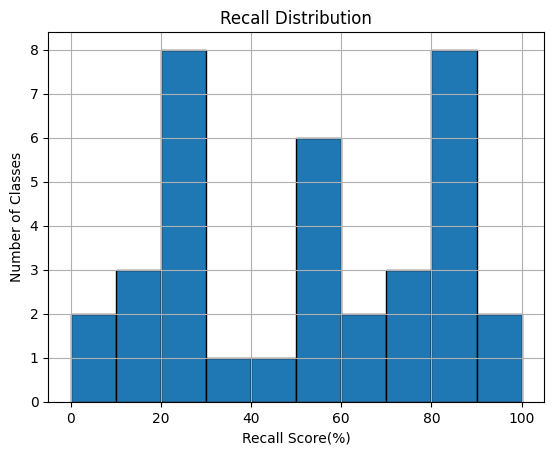

In [17]:
import pylab as pl

recall_dict = defaultdict()
for k,v in stat_dict.items():
    recall_dict[k] = v[2]

recall_list = []
for k,v in recall_dict.items():
    recall_list.append(v*100)
   
d = {'Recall': recall_list}
tinydf = pd.DataFrame(data=d)



hist = tinydf.hist(edgecolor='black', bins = [0,10,20,30,40,50,60,70,80,90,100])
pl.title("Recall Distribution")
pl.xlabel("Recall Score(%)")
pl.ylabel("Number of Classes")
print(tinydf)

## log_loss histogram

    logloss
0    0.0835
1    0.1038
2    0.1922
3    0.2552
4    0.0980
5    0.0840
6    0.0556
7    0.0784
8    0.0622
9    0.0827
10   0.0641
11   0.0712
12   0.1894
13   0.0567
14   0.0575
15   0.1510
16   0.0814
17   0.0896
18   0.1133
19   0.0948
20   0.0657
21   0.0407
22   0.3012
23   0.0680
24   0.0637
25   0.0732
26   0.1546
27   0.2950
28   0.1280
29   0.0861
30   0.1004
31   0.0819
32   0.0836
33   0.0431
34   0.1866
35   0.0733


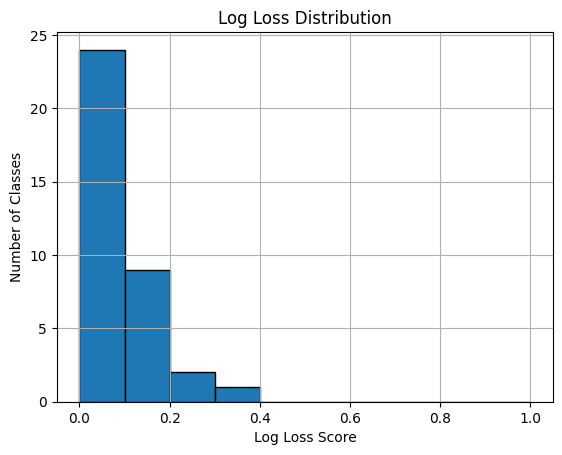

In [18]:
import pylab as pl

logloss_dict = defaultdict()
for k,v in stat_dict.items():
    logloss_dict[k] = v[5]

logloss_list = []
for k,v in logloss_dict.items():
    logloss_list.append(v)
   
d = {'logloss': logloss_list}
tinydf = pd.DataFrame(data=d)

hist = tinydf.hist(edgecolor='black', bins = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
pl.title("Log Loss Distribution")
pl.xlabel("Log Loss Score")
pl.ylabel("Number of Classes")
print(tinydf)

## Brier Score Loss

    brierloss
0      0.0198
1      0.0297
2      0.0521
3      0.0741
4      0.0196
5      0.0180
6      0.0125
7      0.0163
8      0.0148
9      0.0229
10     0.0128
11     0.0150
12     0.0550
13     0.0112
14     0.0116
15     0.0353
16     0.0174
17     0.0228
18     0.0305
19     0.0243
20     0.0153
21     0.0103
22     0.0913
23     0.0147
24     0.0164
25     0.0162
26     0.0315
27     0.0891
28     0.0310
29     0.0191
30     0.0202
31     0.0166
32     0.0184
33     0.0113
34     0.0522
35     0.0137


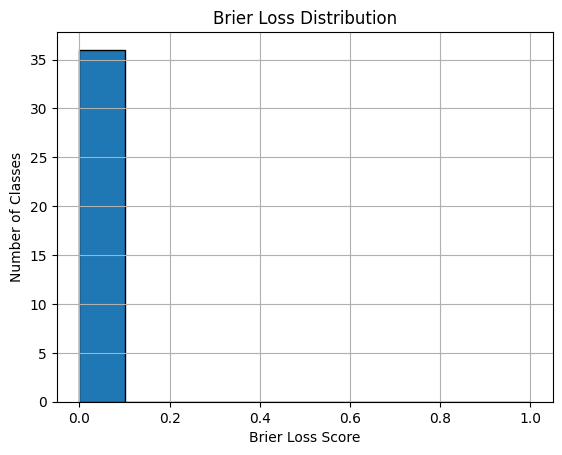

In [19]:

brierloss_dict = defaultdict()
for k,v in stat_dict.items():
    brierloss_dict[k] = v[6]

brierloss_list = []
for k,v in brierloss_dict.items():
    brierloss_list.append(v)
   
d = {'brierloss': brierloss_list}
tinydf = pd.DataFrame(data=d)

hist = tinydf.hist(edgecolor='black', bins = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
pl.title("Brier Loss Distribution")
pl.xlabel("Brier Loss Score")
pl.ylabel("Number of Classes")
print(tinydf)

# Custom Input Prediction

In [20]:
#text = "How do I get my mom's license taken away. My mom is 66, on disability for multiple sclerosis. She's been unable to work for about a decade. She has cataracts. She has neuropathy. She has 0 reaction time. She has had a fender bender on every single corner of her last car, which my brother then totaled. She also has no night vision. She also falls asleep all the time. ALMOST like like narcolepsy. It's mostly her overextending herself, but she will nod off driving or sleep in parking lots til she feels ok. She also has lymphedema in her legs which are swollen enough to impede driving. The last year she was driving she received 19 red light tickets. She agreed not to drive. And the insurance paid for her car. Now she's bought a new one, about 6 months later. Our relationship is terrible. I hate her. But I want her licence taken away before she kills or cripples someone(s). I'm no contact with her, but my brother still tries and he cares about this a lot. I've spoken with the DMV IN MY state, not very helpful. Can i contact her insurance? Do I contact the police? Has this happened to anyone"
text = "I had my car parked at work and someone stole my car. I went to report my car stolen at the police station but I got a call later saying I can’t report it stolen because a title change occurred. I never sold my car, never signed anything. I feel completely powerless and violated. I honestly don’t know what to do. If I find out who stole my car I will most likely snap because I don’t know what else to do. This has never happened to me. What legal steps can I take? Edit: I can’t find the title. My sister was coming back home from the army and I intended on giving her the car when she arrived. I most likely left the title in the car."
print(text)
input = sent2vec(text)
input = np.array(input)

predictions = defaultdict() 
prob = defaultdict()
c_logloss = defaultdict()

for cls in class_list:
    predictions[cls] = classifier[cls].predict([input])
    prob[cls] = classifier[cls].predict_proba([input])

for k,v in predictions.items():   
    if v > 0:
        print(k, v, end = ' ')
        print(np.round(prob[k][0][1], 4))


I had my car parked at work and someone stole my car. I went to report my car stolen at the police station but I got a call later saying I can’t report it stolen because a title change occurred. I never sold my car, never signed anything. I feel completely powerless and violated. I honestly don’t know what to do. If I find out who stole my car I will most likely snap because I don’t know what else to do. This has never happened to me. What legal steps can I take? Edit: I can’t find the title. My sister was coming back home from the army and I intended on giving her the car when she arrived. I most likely left the title in the car.
CR-00-00-00-00 [1.] 0.8102
CR-01-00-00-00 [1.] 0.9483
MO-00-00-00-00 [1.] 0.688
TO-00-00-00-00 [1.] 0.9081
TR-00-00-00-00 [1.] 0.9993
TR-01-00-00-00 [1.] 0.7354
TR-04-00-00-00 [1.] 0.9996
